In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect, LangDetectException
import contractions

# Define stop words for text cleaning
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Akmal
[nltk_data]     Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Akmal
[nltk_data]     Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Akmal
[nltk_data]     Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the dataset
df = pd.read_csv("cyberbullying_tweets.csv")

In [3]:
df.cyberbullying_type.value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [4]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.demojize(text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [5]:
df['tweet_clean'] = [clean_tweet(tweet) for tweet in df['tweet_text']]

In [6]:
df.drop_duplicates("tweet_clean", inplace=True)

In [7]:
df.cyberbullying_type.value_counts()

cyberbullying_type
religion               7912
age                    7822
ethnicity              7415
gender                 7295
not_cyberbullying      6109
other_cyberbullying    4929
Name: count, dtype: int64

In [8]:
# Data preprocessing
labEncoder = LabelEncoder()
labelsEncoded = labEncoder.fit_transform(df["cyberbullying_type"])

In [9]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['tweet_clean'], labelsEncoded, test_size=0.2, random_state=42)
print((train_texts.shape, train_labels.shape, val_texts.shape, val_labels.shape))

((33185,), (33185,), (8297,), (8297,))


In [10]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

In [11]:
# Transform text data into numerical features
train_features = vectorizer.fit_transform(train_texts)
val_features = vectorizer.transform(val_texts)

In [12]:
# Initialize Naive Bayes classifier
model = MultinomialNB()

In [13]:
# Train the model
model.fit(train_features, train_labels)

MultinomialNB()

In [14]:
# Make predictions on validation data
val_predictions = model.predict(val_features)

In [15]:
# Calculate accuracy and classification report
accuracy = accuracy_score(val_labels, val_predictions)
report = classification_report(val_labels, val_predictions)

print(f"Validation Accuracy: {accuracy:.4f}")
print(report)

Validation Accuracy: 0.7751
              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1526
           1       0.85      0.93      0.89      1515
           2       0.82      0.83      0.82      1463
           3       0.64      0.39      0.48      1261
           4       0.63      0.30      0.41       995
           5       0.81      0.98      0.89      1537

    accuracy                           0.78      8297
   macro avg       0.75      0.74      0.72      8297
weighted avg       0.76      0.78      0.75      8297



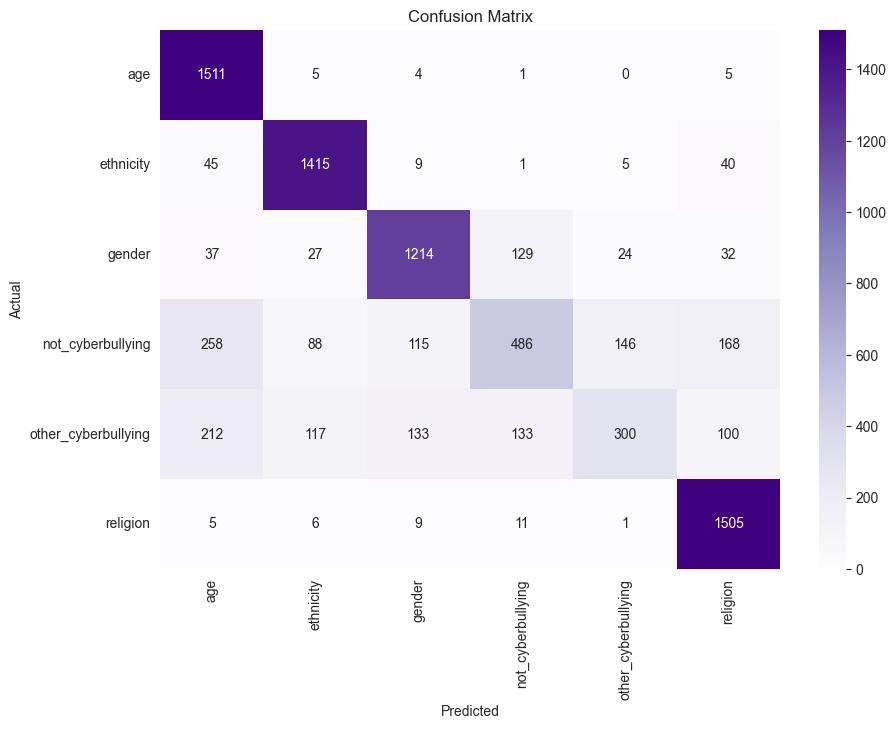

In [16]:
# Compute confusion matrix
cm = confusion_matrix(val_labels, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labEncoder.classes_, yticklabels=labEncoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Test predictions
for _ in range(10):
    random_idx = np.random.randint(len(val_texts))
    text, label = val_texts.iloc[random_idx], labEncoder.classes_[val_labels[random_idx]]
    val_features = vectorizer.transform([text])
    prediction = model.predict(val_features)
    prediction = labEncoder.classes_[prediction[0]]
    print("=============================================")
    print(f"Text:\n{text}")
    print(f"Actual: {label}\tPredicted: {prediction}")
    print("=============================================")

IndexError: index 22511 is out of bounds for axis 0 with size 8297